In [6]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss
from sklearn.model_selection import train_test_split
from IPython.display import display
import joblib

In [7]:
# import the data
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1
test['train_test'] = 0
all_data = pd.concat([training,test])

print("Import Data Complete")

Import Data Complete


In [8]:
# Handle missing values in text columns
for col in ["prompt", "response_a", "response_b"]:
    training[col] = training[col].fillna("")
    test[col] = test[col].fillna("")

# Add response_a_length and response_b_length columns
training['response_a_length'] = training['response_a'].apply(len)
training['response_b_length'] = training['response_b'].apply(len)
test['response_a_length'] = test['response_a'].apply(len)
test['response_b_length'] = test['response_b'].apply(len)

In [9]:
# Combine model_a and model_b
all_models = pd.concat([training['model_a'], training['model_b']])

# Count occurrences of each model name across both columns
model_counts = all_models.value_counts()
print("\nModel occurrence counts (across model_a and model_b):")
print(model_counts)


Model occurrence counts (across model_a and model_b):
gpt-4-1106-preview          7387
gpt-3.5-turbo-0613          7083
gpt-4-0613                  6165
claude-2.1                  5583
claude-instant-1            4136
                            ... 
falcon-180b-chat             286
openchat-3.5-0106            244
qwen1.5-7b-chat              208
qwen1.5-4b-chat              200
mistral-7b-instruct-v0.2     100
Name: count, Length: 64, dtype: int64


In [10]:
# Combine model_a and model_b, count occurrences
all_models = pd.concat([training['model_a'], training['model_b']])
model_counts = all_models.value_counts()

# Keep only models that occur at least 1000 times
frequent_models = model_counts[model_counts >= 1000].index

# Filter training data to keep only rows where both model_a and model_b are frequent
training = training[
    training['model_a'].isin(frequent_models) & training['model_b'].isin(frequent_models)
]

print("Filtered training shape:", training.shape)
print("Remaining unique models:", len(frequent_models))

Filtered training shape: (44514, 12)
Remaining unique models: 40


In [11]:
# Count the number of each winner type in the training data
num_a = training['winner_model_a'].sum()
num_b = training['winner_model_b'].sum()
num_tie = training['winner_tie'].sum()

print(f"winner_model_a: {num_a}")
print(f"winner_model_b: {num_b}")
print(f"winner_tie: {num_tie}")

winner_model_a: 15607
winner_model_b: 15275
winner_tie: 13632


In [12]:
# data handling
# Vectorization of text data using TF-IDF
vectorizer_prompt = TfidfVectorizer(max_features=150)
vectorizer_response_a = TfidfVectorizer(max_features=150)
vectorizer_response_b = TfidfVectorizer(max_features=150)

# Fit and transform training data
temp_prompt = vectorizer_prompt.fit_transform(training["prompt"])
temp_response_a = vectorizer_response_a.fit_transform(training["response_a"])
temp_response_b = vectorizer_response_b.fit_transform(training["response_b"])

# Print vector dimensions
print("Number of elements for 'prompt':", temp_prompt.shape)
print("Number of elements for 'response a':", temp_response_a.shape)
print("Number of elements for 'response b':", temp_response_b.shape)

# Extract winner label from row
def get_winner(row):
    if row['winner_model_a'] == 1:
        return 0
    if row['winner_model_b'] == 1:
        return 1
    if row['winner_tie'] == 1:
        return 2
    return -1

# Apply winner extraction
training['winner'] = training.apply(get_winner, axis=1)
train_y = training["winner"].values

# Concatenate feature arrays
train_X = np.hstack([temp_prompt.toarray(), temp_response_a.toarray(), temp_response_b.toarray()])

Number of elements for 'prompt': (44514, 150)
Number of elements for 'response a': (44514, 150)
Number of elements for 'response b': (44514, 150)


In [13]:
# Split data into training and validation sets
train_X_train, train_X_val, train_y_train, train_y_val = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42, shuffle=True
)

# Train logistic regression model
start = datetime.now()
model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    learning_rate_init=0.001,  # Set initial learning rate
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)
model.fit(train_X_train, train_y_train)
end = datetime.now()

# Print execution time
execution_time = (end - start).total_seconds() / 60
print(f"The time of execution is: {execution_time:.4f} minutes")
print("Model Training Complete")

The time of execution is: 0.1093 minutes
Model Training Complete


Prediction Probabilities (columns: A | B | Tie):
[[0.4019226  0.36360045 0.23447696]
 [0.17754763 0.47516044 0.34729193]
 [0.33344232 0.43111009 0.23544759]
 ...
 [0.53960051 0.24773276 0.21266674]
 [0.24118609 0.50283198 0.25598192]
 [0.33691085 0.27395246 0.38913669]]

Accuracy: 0.4355


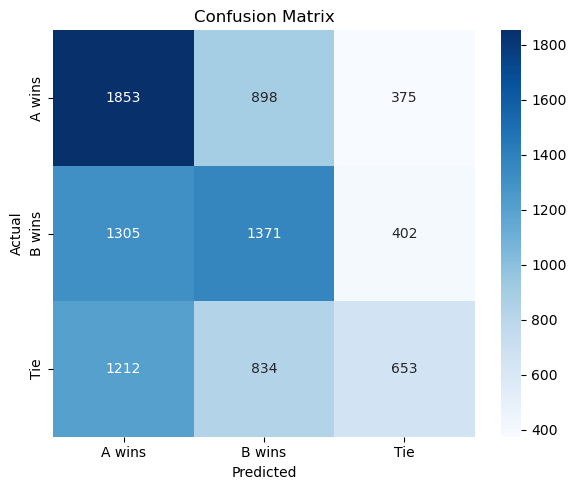


Validation Execution Time: 0.57 seconds


In [14]:
# Predict class labels and probabilities on validation set
start = datetime.now()
value_y_predict = model.predict(train_X_val)
value_y_probabilities = model.predict_proba(train_X_val)

print("Prediction Probabilities (columns: A | B | Tie):")
print(value_y_probabilities)

# Calculate evaluation metrics
cm = confusion_matrix(train_y_val, value_y_predict)
accuracy = model.score(train_X_val, train_y_val)
macro_precision = precision_score(train_y_val, value_y_predict, average='macro')
macro_recall = recall_score(train_y_val, value_y_predict, average='macro')
micro_precision = precision_score(train_y_val, value_y_predict, average='micro')
micro_recall = recall_score(train_y_val, value_y_predict, average='micro')

print(f"\nAccuracy: {accuracy:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['A wins', 'B wins', 'Tie'], 
            yticklabels=['A wins', 'B wins', 'Tie'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

end = datetime.now()
execution_time = (end - start).total_seconds()
print(f"\nValidation Execution Time: {execution_time:.2f} seconds")


In [15]:
model_log_loss = log_loss(train_y_val, value_y_probabilities)
print('Model Log loss:', model_log_loss)

Model Log loss: 1.0635779523872035


In [16]:
# model prediction
# transform test data using the trained vectorizers
temp_test_prompt = vectorizer_prompt.transform(test["prompt"])
temp_test_response_a = vectorizer_response_a.transform(test["response_a"])
temp_test_response_b = vectorizer_response_b.transform(test["response_b"])

# concatenate all transformed fields to form the final test feature matrix
test_X = np.hstack([
    temp_test_prompt.toarray(),
    temp_test_response_a.toarray(),
    temp_test_response_b.toarray()
])

# predict class probabilities on the test data
value_test_y_probabilities = model.predict_proba(test_X)

# create a DataFrame for better visualization
proba_df = pd.DataFrame(
    np.round(value_test_y_probabilities, 4),
    columns=["Prob_A_Wins", "Prob_B_Wins", "Prob_Tie"]
)

print("Model Winner Prediction Probabilities:\n")
display(proba_df)
joblib.dump(model, 'mymodel.pkl')
joblib.dump(vectorizer_prompt, 'vectorizer_prompt.pkl')
joblib.dump(vectorizer_response_a, 'vectorizer_response_a.pkl')
joblib.dump(vectorizer_response_b, 'vectorizer_response_b.pkl')


Model Winner Prediction Probabilities:



,Prob_A_Wins,Prob_B_Wins,Prob_Tie
0,0.2040,0.2230,0.5730
1,0.5117,0.2268,0.2615
2,0.3164,0.3429,0.3407


['vectorizer_response_b.pkl']